## Bibliotecas e dados

In [121]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split

#mpl.rcParams['figure.figsize'] = [10, 5]

In [3]:
#df = pd.read_csv("chuva_fortaleza.csv")
#df.set_index(df['Year'], inplace=True) 
#df = df.drop('Year', 1)
#df = df['Milimitros']
#df.plot()
#df.head()

In [4]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_dehli.csv")

In [5]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)
# df = df['meantemp']


C:\Users\lucas\AppData\Local\Temp/ipykernel_2896/3726606635.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('date', 1)


In [6]:
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [ ]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

## Plot

<AxesSubplot:xlabel='date'>

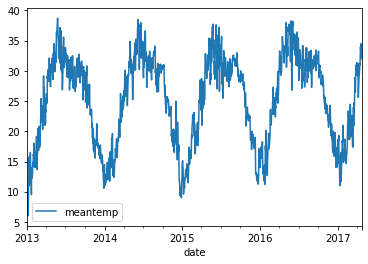

In [7]:
df.plot()

## Decomposição

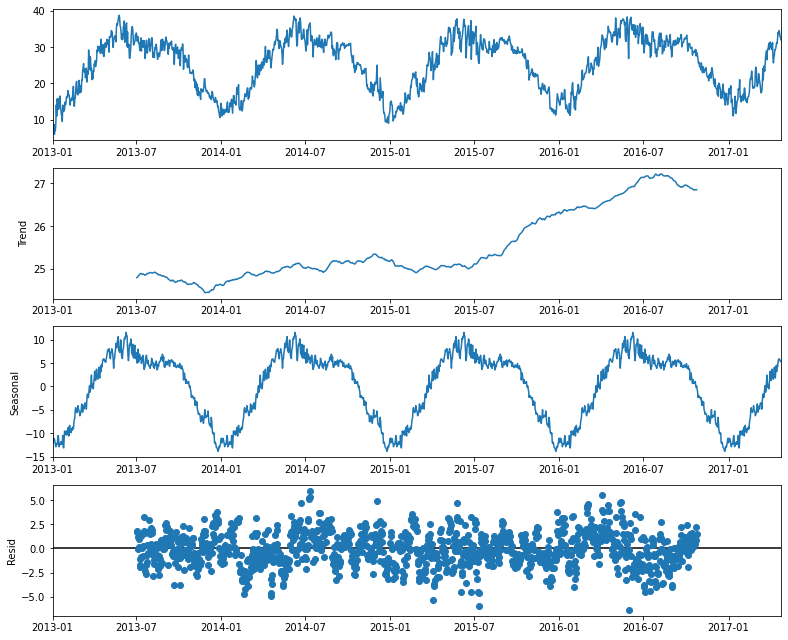

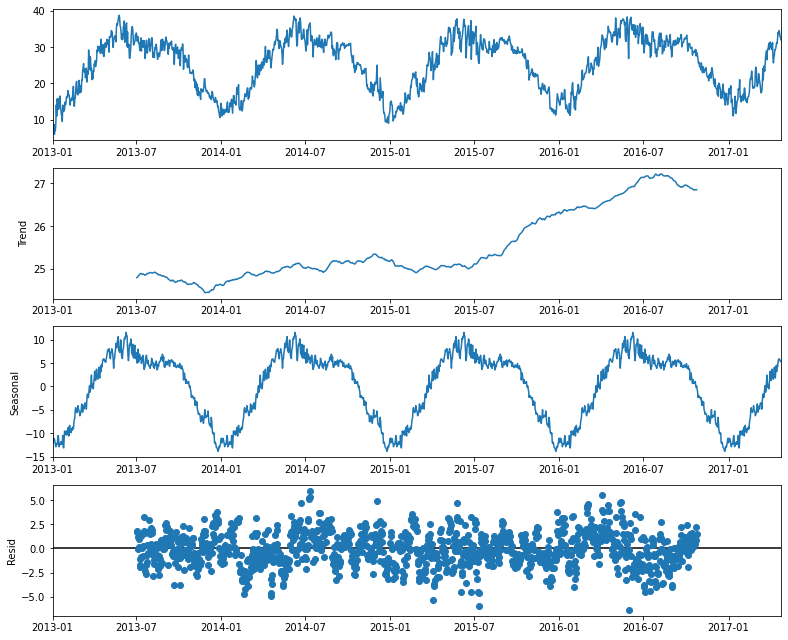

In [152]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Estacionariedade

In [9]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df, regression='ct')
print(pvalue)
print(lags)

0.3993675522472093
10


In [128]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey Fuller (ADF) Test
result = adfuller(df['meantemp'].values, autolag='AIC')
print('ADF Statistic:', result[0], 'p-value:', result[1])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
result = kpss(df['meantemp'].values, nlags="auto", regression='c')
print('KPSS Statistic: ', result[0], 'p-value: ', result[1])

ADF Statistic: -2.375315316765393 p-value: 0.14882501558674888
KPSS Statistic:  0.11464885413945343 p-value:  0.1


C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [131]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey Fuller (ADF) Test
result = adfuller(dfd1['meantemp'].values, autolag='AIC')
print('ADF Statistic:', result[0], 'p-value:', result[1])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
result = kpss(dfd1['meantemp'].values, nlags="auto", regression='c')
print('KPSS Statistic: ', result[0], 'p-value: ', result[1])

ADF Statistic: -16.94253134624252 p-value: 9.593523131253509e-30
KPSS Statistic:  0.06454485172315133 p-value:  0.1


C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Diferenciação

<AxesSubplot:xlabel='date'>

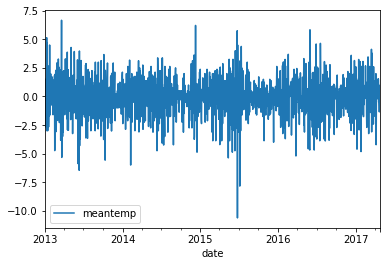

In [10]:
df.diff().plot()

<AxesSubplot:ylabel='Frequency'>

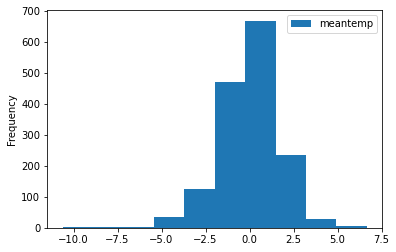

In [11]:
df.diff().plot.hist()

In [12]:
dfd1 = df.diff().dropna()

In [13]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1, regression='ct')
print(pvalue)
print(lags)

0.0
9


## Autocorrelação

### Correlação

In [14]:
df.corrwith(df.shift(1))

meantemp    0.974134
dtype: float64

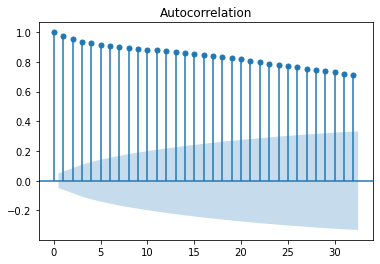

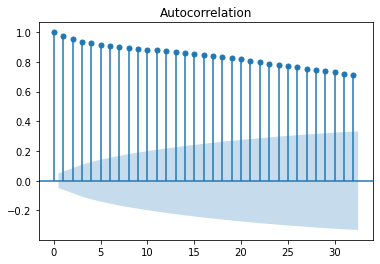

In [15]:
plot_acf(df)

Correlação com série diferenciada

In [16]:
dfd1.corrwith(dfd1.shift(1))

meantemp   -0.156369
dtype: float64

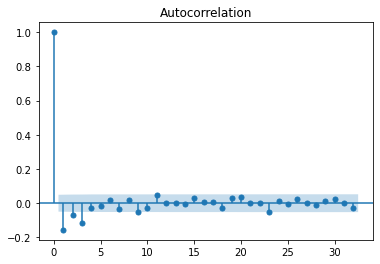

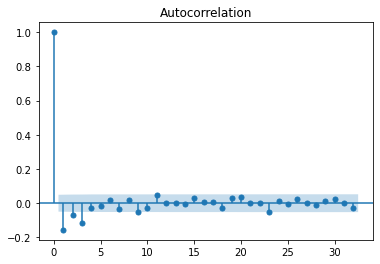

In [17]:
plot_acf(dfd1)

## Autocorrelação Parcial

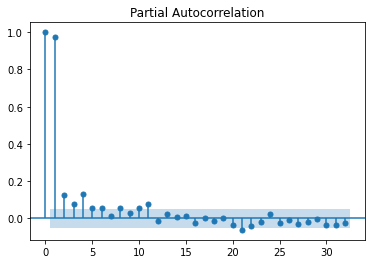

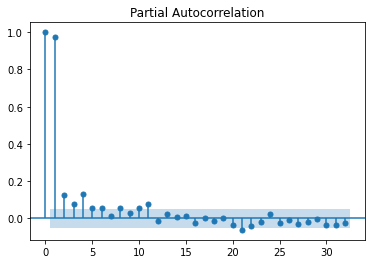

In [18]:
plot_pacf(df)

Correlação Parcial com série diferenciada

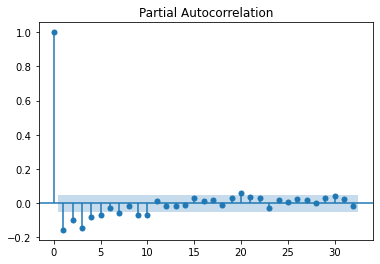

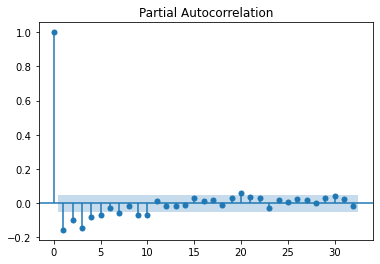

In [19]:
plot_pacf(dfd1)

### ARIMA

ARIMA (5,1,3)

In [32]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
df_train.head()

,meantemp
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [33]:
arima_model = ARIMA(df_train, order=(5,1,3))

In [34]:
res_arima = arima_model.fit()

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
res_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2232.011
Date:                Tue, 12 Apr 2022   AIC                           4482.022
Time:                        10:57:22   BIC                           4527.682
Sample:                    01-01-2013   HQIC                          4499.236
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1960      0.071      2.774      0.006       0.058       0.335
ar.L2         -0.7646      0.051    -14.847      0.000      -0.866      -0.664
ar.L3          0.4747      0.095      4.989      0.000       0.288       0.661
ar.L4          0.0184      0.034      0.546      0.585      -0.048       0.084
ar.L5         -0.0576      0.036     -1.578      0.115      -0.129       0.014
ma.L1         -0.4138      0.069     -6.032      0.000      -0.548      -0.279
ma.L2          0.7060      0.035     20.265      0.000       0.638       0.774
ma.L3         -0.7458      0.068    -10.922      0.000      -0.880      -0.612
sigma2         2.5926      0.086     30.169      0.000       2.424       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               210.88
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.45
Prob(H) (two-sided):                  0.72   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


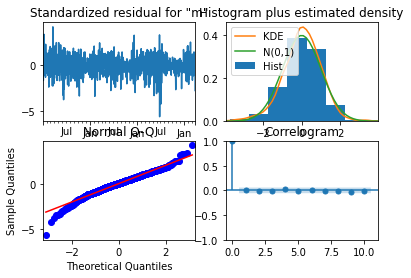

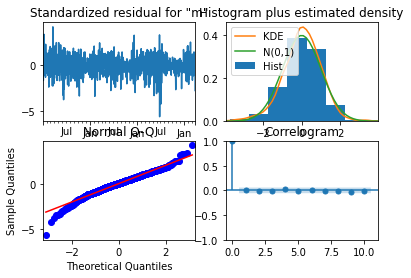

In [37]:
res_arima.plot_diagnostics()

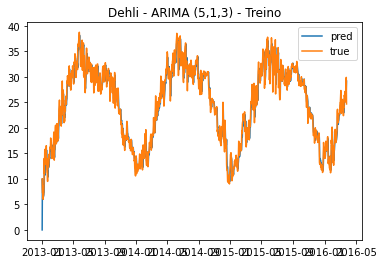

In [80]:
#Previsão do treino
fig, ax = plt.subplots()
ax.plot(res_arima.predict(), label='pred')
ax.plot(df_train, label='true')
plt.title('Dehli - ARIMA (5,1,3) - Treino')
plt.legend()

In [63]:
res_arima.forecast()

2016-03-27    25.115775
Freq: D, dtype: float64

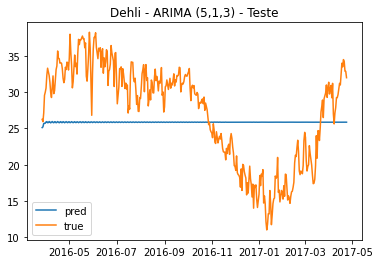

In [87]:
#Previsão do conjunto de teste
start_index = "2016-03-27"#df_test.index[0]
end_index = "2017-04-24"#df_test.index[-1]
# forecast = res_arima.predict(start=start_index, end=end_index)
forecast = res_arima.forecast(steps=394)
forecast

fig, ax = plt.subplots()
ax.plot(forecast, label='pred')
ax.plot(df_test, label='true')
plt.title('Dehli - ARIMA (5,1,3) - Teste')
plt.legend()

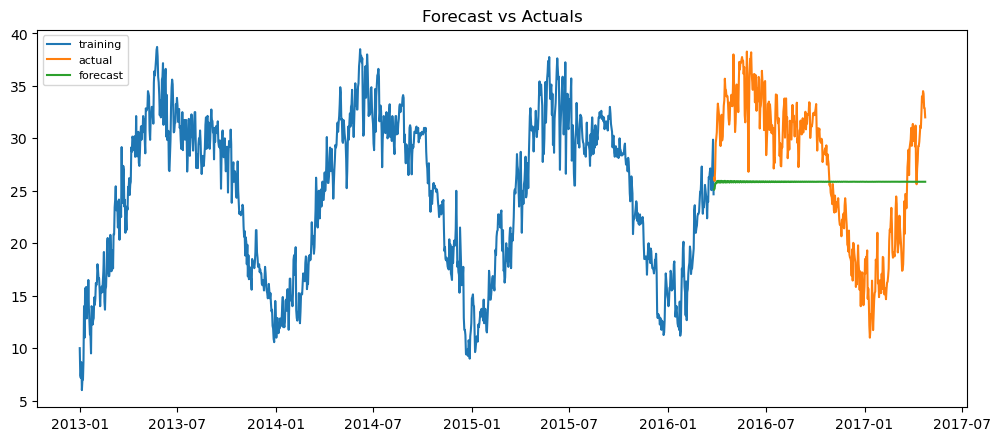

In [127]:
# Build Model 
#model = ARIMA(df_train, order=(2, 0, 1))  
fitted = res_arima  

# Forecast
fc = fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

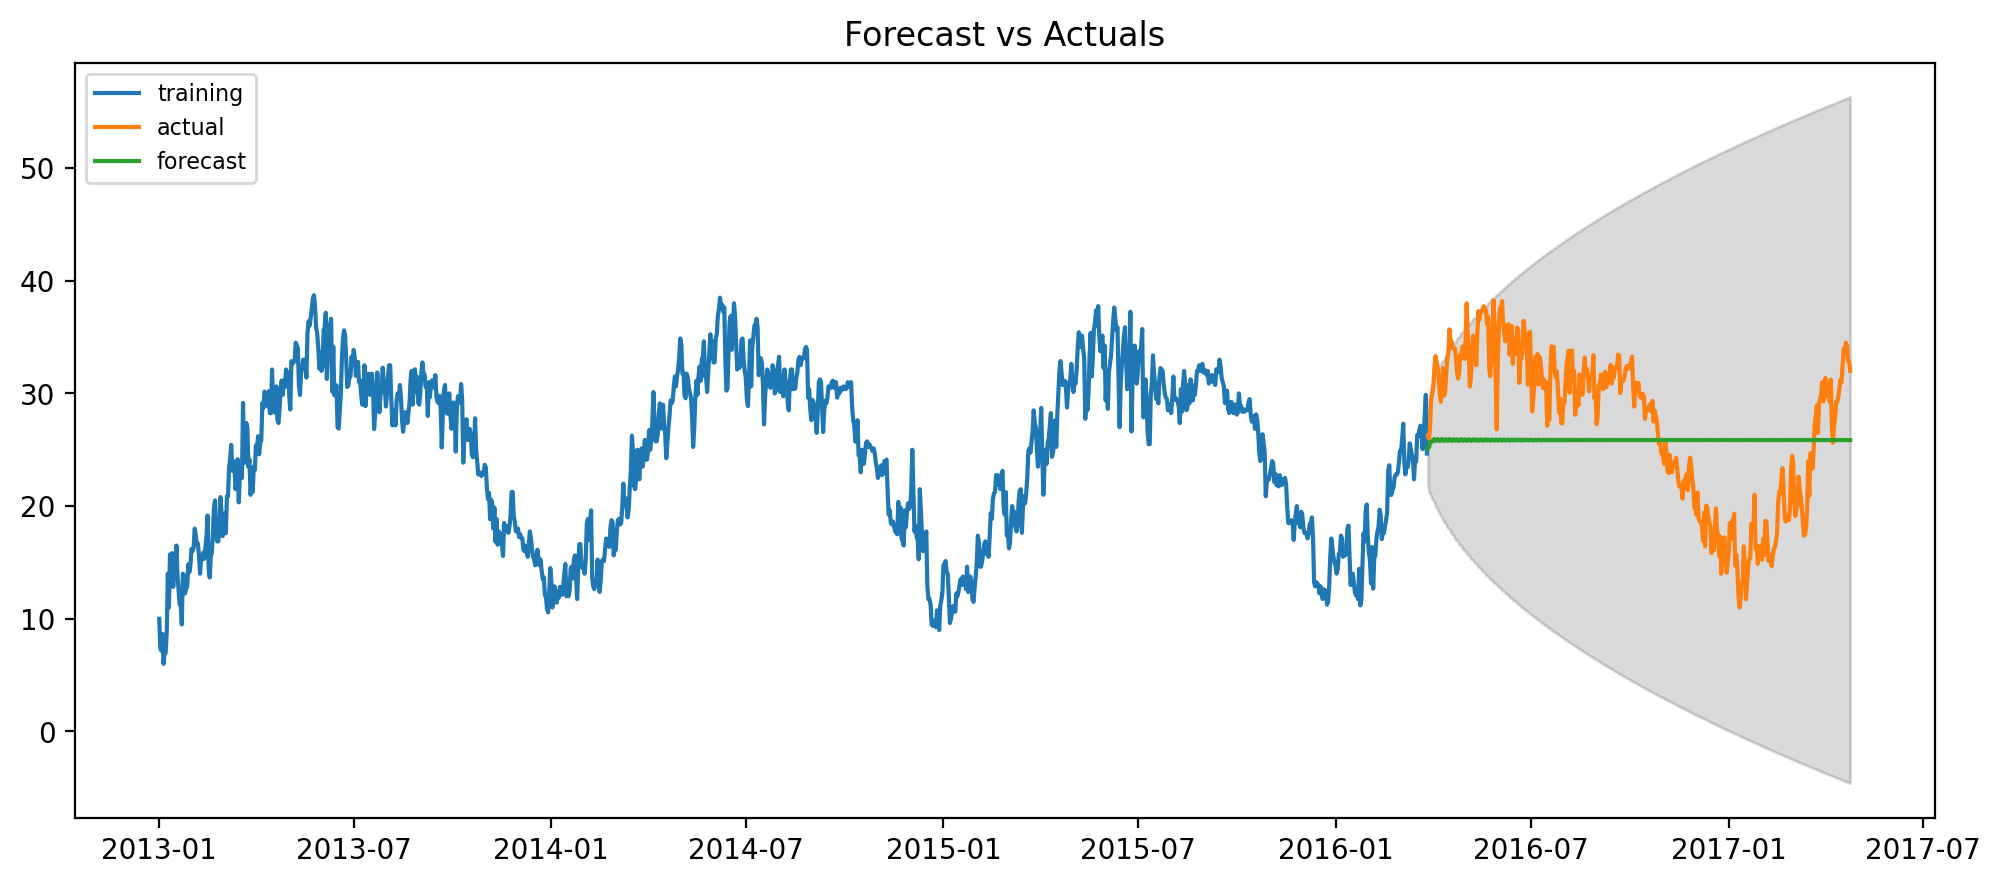

In [140]:
import numpy as np

fitted = res_arima  
fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*75)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=df_test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=df_test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [88]:
results = {}

In [89]:
print('model Results')
print('r2' , r2_score(forecast, df_test))
print('mse' ,mean_squared_error(forecast, df_test))
print('mae', mean_absolute_error(forecast, df_test))
results['MA'] = {'r2':r2_score(forecast, df_test), \
                 'mse': mean_squared_error(forecast, df_test), 
                 'mae': mean_absolute_error(forecast, df_test)}

model Results
r2 -14593.473368864228
mse 48.137528859693944
mae 6.243535486960721


### Auto ARIMA

In [81]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4494.045, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11018.217, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9511.186, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4512.618, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4492.004, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4531.154, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4493.975, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4489.732, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4523.647, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4531.821, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4491.714, 

In [82]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2239.866
Date:                Tue, 12 Apr 2022   AIC                           4489.732
Time:                        11:30:29   BIC                           4515.102
Sample:                             0   HQIC                          4499.296
                               - 1181                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0506      0.030      1.672      0.094      -0.009       0.110
ar.L1          1.5616      0.055     28.192      0.000       1.453       1.670
ar.L2         -0.5638      0.055    -10.282      0.000      -0.671      -0.456
ma.L1         -0.7881      0.045    -17.488      0.000      -0.876      -0.700
sigma2         2.5920      0.086     30.135      0.000       2.423       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               227.00
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.46
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


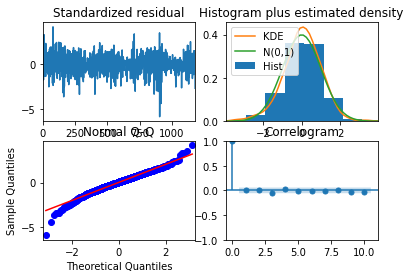

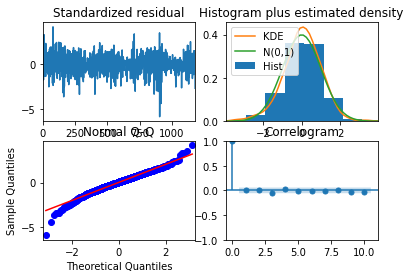

In [83]:
auto_arima.plot_diagnostics()

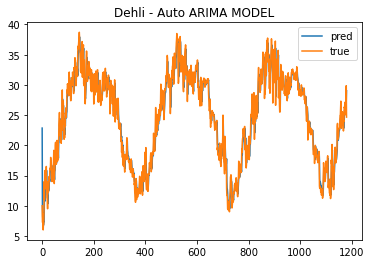

In [84]:
fig, ax = plt.subplots()
ax.plot(auto_arima.predict_in_sample(), label='pred')
ax.plot(df_train.values, label='true')
plt.title('Dehli - Auto ARIMA MODEL')
plt.legend()

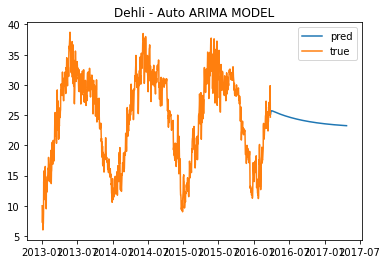

In [111]:
fig, ax = plt.subplots()
ax.plot(pd.DataFrame(auto_arima.predict(n_periods=394), index=df_test.index), label='pred')
#ax.plot(df_train.values, label='true')
ax.plot(df_train, label='true')
plt.title('Dehli - Auto ARIMA MODEL')
plt.legend()

In [94]:
pred = auto_arima.predict(n_periods=394)

print('MA model Results')
print('r2' , r2_score(pred, df_test))
print('mse' ,mean_squared_error(pred, df_test))
print('mae', mean_absolute_error(pred, df_test))
results['MA'] = {'r2':r2_score(pred, df_test), \
                 'mse': mean_squared_error(pred, df_test), 
                 'mae': mean_absolute_error(pred, df_test)}

MA model Results
r2 -95.85896516856229
mse 49.68913135264666
mae 6.356182978044135


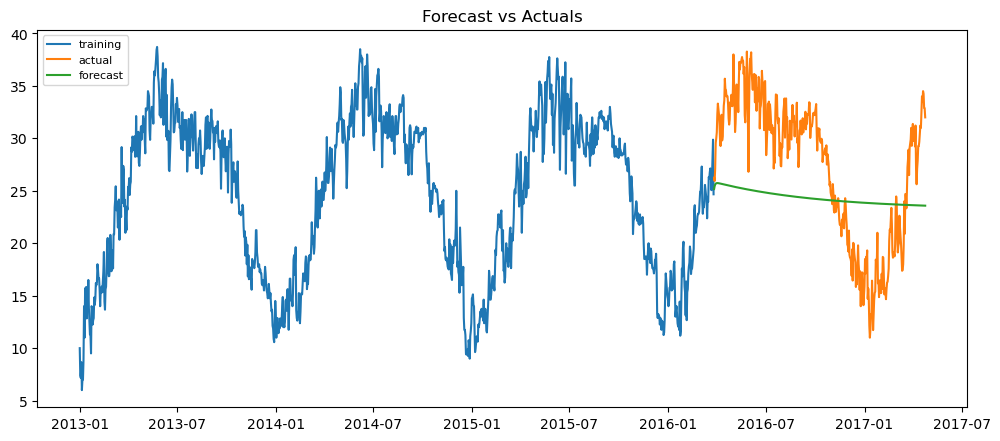

In [120]:
# Build Model 
model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

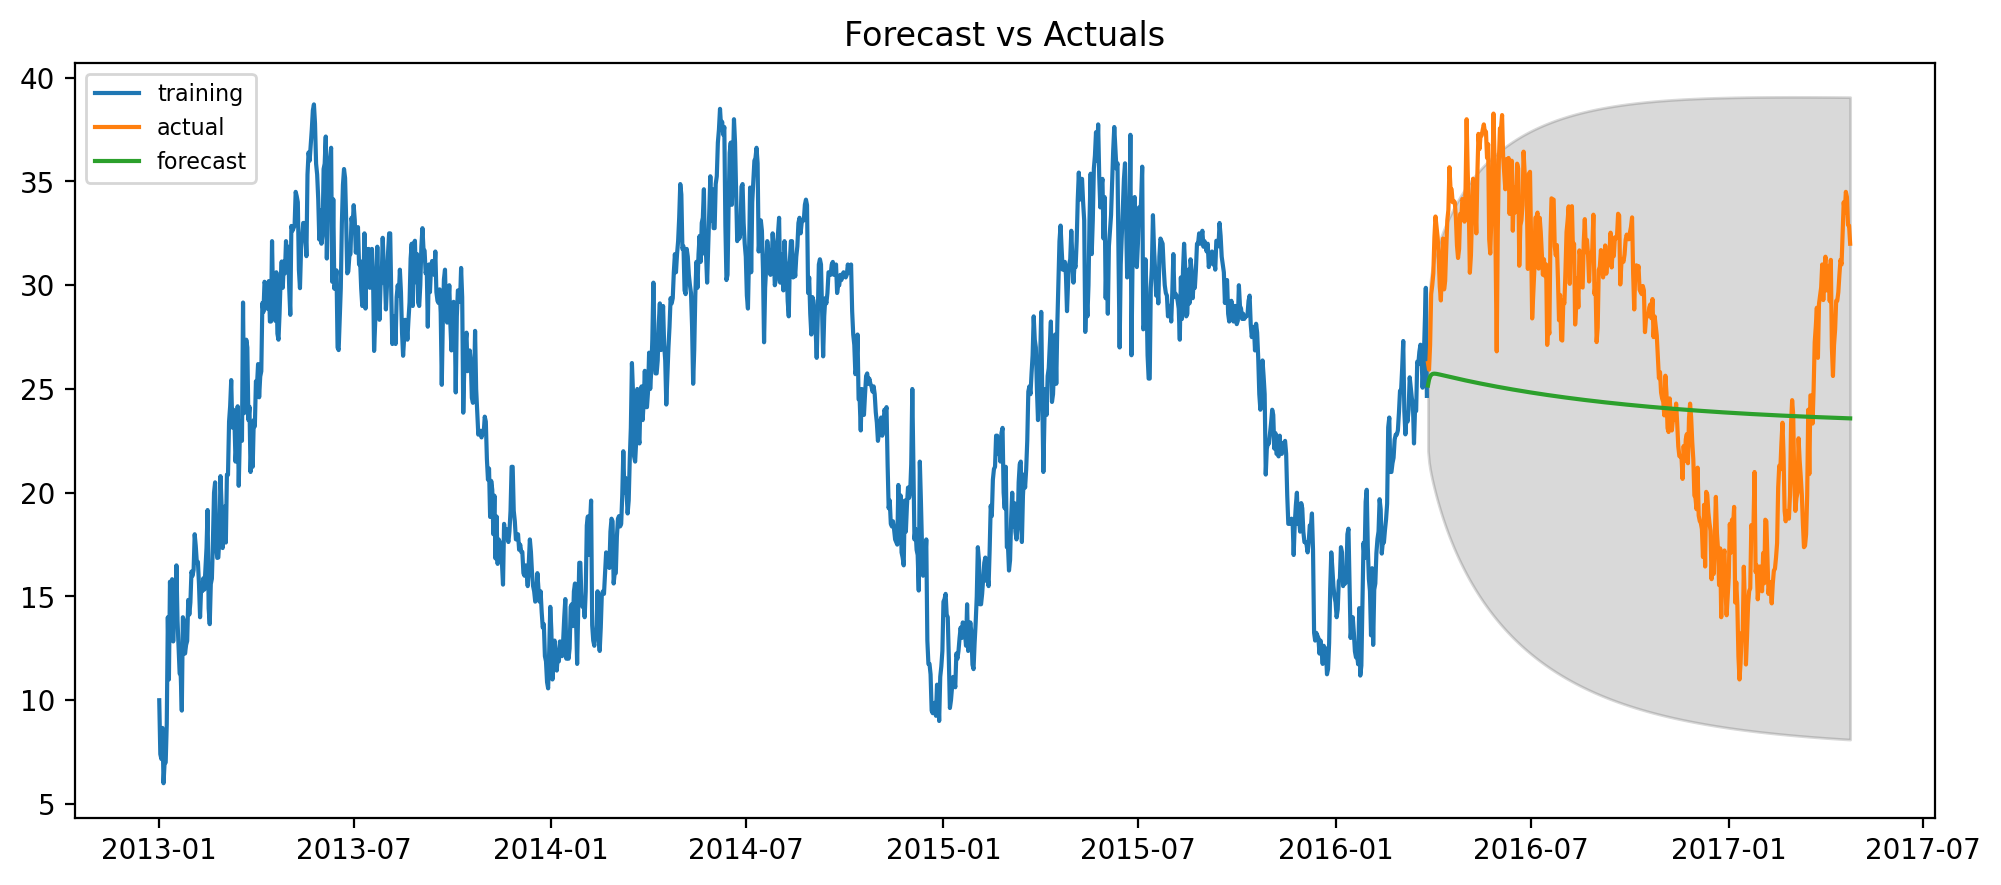

In [141]:
import numpy as np

model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  

fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*75)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=df_test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=df_test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Machine Learning

### Feature Engineering

In [91]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [114]:
X = get_lags(df, 3)
X.head()

,meantemp-1,meantemp-2,meantemp-3
date,,,
2013-01-04,7.166667,7.400000,10.000000
2013-01-05,8.666667,7.166667,7.400000
2013-01-06,6.000000,8.666667,7.166667
2013-01-07,7.000000,6.000000,8.666667
2013-01-08,7.000000,7.000000,6.000000


In [115]:
y = df.reindex(X.index)
y.head()

,meantemp
date,
2013-01-04,8.666667
2013-01-05,6.000000
2013-01-06,7.000000
2013-01-07,7.000000
2013-01-08,8.857143


In [122]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

In [123]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2, weights='distance')
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [124]:
resultsco2 = {}

In [125]:
print('Dehli - KNN model Results')
print(r2_score(neigh.predict(X_test), y_test))
print(mean_squared_error(neigh.predict(X_test), y_test))
print(mean_absolute_error(neigh.predict(X_test), y_test))
resultsco2['KNN'] = {'r2':r2_score(neigh.predict(X_test), y_test), \
                 'mse': mean_squared_error(neigh.predict(X_test), y_test), 
                 'mae': mean_absolute_error(neigh.predict(X_test), y_test)}

Dehli - KNN model Results
0.9059947227518385
4.053096684251233
1.5562647159873026


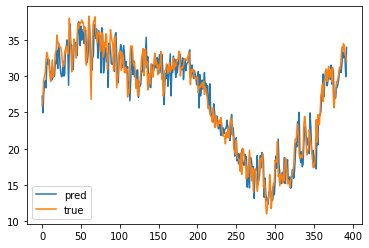

In [126]:
fig, ax = plt.subplots()
ax.plot(neigh.predict(X_test).flatten(), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

### Support Vector Regression

### MPL